In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cuqi

# Gravity anomali

#### Introduction
A subsurface body with a density contrast to its surroundings will cause a gravity anomali. The gravity anomali field will depend on the body's depth, shape, size, and density constrast. 

We construct a simple example where a spherical body with radius $R=1000$ m, density constrast $\Delta\rho = 800$ $\text{kg}/\text{m}^3$, and center depth $z=1500$ m causes a gravity anomali. This could represent a very simple model of iron ore embedded in sedimentary rock. The vertical gravity anomali signal is then:
\begin{equation}
    \Delta g_z = \frac{4}{3} \pi G \left(\frac{\Delta\rho R^3}{z^2}\right) \left(\frac{1}{1+(x/z)^2}\right)^{3/2}
\end{equation}
where $G$ is the gravitational constant and $x$ is the horizontal distance from the surface point directly above the centre of the body. 

In the inverse problem we measure $\Delta g_z$ in a 1D grid on the surface above the body and seek to infer $z$, $\Delta\rho$ and $R$. Note that the signal is uniquely determined from $z$ and the product $\Delta\rho R^3$, which means $z$ can be inferred from measurements, but $\Delta\rho$ and $R$ can not be resolved. 

#### Forward model

To solve the inverse problem we must define the non-linear forward model. The gravity anomali model is not included in the CUQIpy library, so we define it ourselves and wrap it as a CUQIpy model. Note that we also include the gradient of the model. This is nessecary to use gradient based samplers like NUTS later, but can be omitted if gradient based samplers are not needed. 

In [2]:
# Measurement grid
m = 100 # data dimension
xx = np.linspace(-8000, 8000, m)

# gravitational constant N m2 kg−2
G = 6.6743e-11 

# true parameters defining the subsurface body
n = 3 # parameter dimension
z_true = 1500 # depth in meters
rho_true = 800 # density contrast in kg m-3
R_true = 1000 # sphere radius in meters
x_true = np.array([z_true, rho_true, R_true])

# Forward model with parameter vector as input and measurements as output
def forward(x_):
    z = x_[0]
    rho = x_[1]
    R = x_[2]
    gz = 4/3*np.pi*G*(rho*R**3/z**2)*(1/(1+(xx/z)**2))**(3/2)
    return gz

# Gradient 
# For non-linear models it is defined from a product of the directional vector dir and the Jacobian of the model
def grad(dir, x_):
    z = x_[0]
    rho = x_[1]
    R = x_[2]

    grad_z = -4/3*np.pi*G*rho*R**3*z* (2*z**2-xx**2) * 1/(z**2/(xx**2+z**2))**(1/2) * 1/(xx**2+z**2)**3
    grad_rho = 4/3*np.pi*G*(R**3/z**2)*(1/(1+(xx/z)**2))**(3/2)
    grad_R = 4*np.pi*G*(rho*R**2/z**2)*(1/(1+(xx/z)**2))**(3/2)

    J = np.vstack([grad_z, grad_rho, grad_R]).T
    
    return dir@J

model = cuqi.model.Model(forward, range_geometry=m, domain_geometry=n, gradient=grad)

#### Prior
To solve the Bayesian inverse problem we must choose an appropriate prior. Below there are two options to choose from; 1) a uniform prior or 2) a broad Gaussian prior with mean offset from the true values.

In [3]:
#x = cuqi.distribution.Uniform(low = np.array([1500, 1000, 800]), high = np.array([2500, 2000, 1200]), name="x")
prior_mean = np.array([1550, 850, 950])
x = cuqi.distribution.GaussianCov(prior_mean, np.array([500, 300, 300])**2)

#### Likelihood
We will assume that the measurements are corrupted by Gaussian noise with standard deviation $10^{-6}$. This is expressed in the likelihood below. 

In [4]:
noise_std = 1e-6
y = cuqi.distribution.GaussianCov(model(x), noise_std**2)

#### Synthetic data

We are now in a position to simulate a synthetic dataset by taking one sample from the likelihood evaluated at the true model parameters.

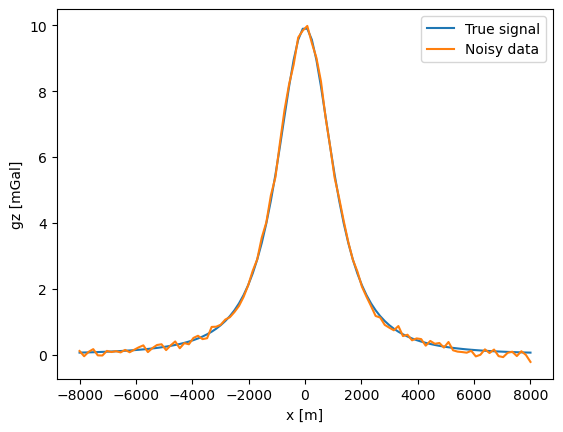

In [5]:
# Evalutate the model to get the noise free data
gz_true = model(x_true)
gz_noisy = y(x=x_true).sample()

plt.figure()
plt.plot(xx,gz_true*1e5, label = "True signal")
plt.plot(xx,gz_noisy*1e5, label = "Noisy data")
plt.xlabel("x [m]")
plt.ylabel("gz [mGal]")
plt.legend()

#### Posterior distribution

From the prior and likelihood we form the posterior distribution. In this case the distribution is 3-dimensional and the model cheap to evaluate, so we start by evaluating the distribution in a grid and plot 2D marginals.

In [6]:
# Form the joint distribution of the likelihood and prior
joint = cuqi.distribution.JointDistribution(y, x)
# Form the posterior by informing the joint about the data
posterior = joint(y=gz_noisy)

In [7]:
# Keep R fixed at truth and mesh z and rho
rhov_R, zv_R = np.meshgrid(np.linspace(10,3000,100), np.linspace(500,2500,100))
rhov_R_f = rhov_R.flatten()
zv_R_f = zv_R.flatten()
# Keep rho fixed at truth and mesh z and R
zv_rho, Rv_rho = np.meshgrid(np.linspace(500,2500,100), np.linspace(600,2000,100))
zv_rho_f = zv_rho.flatten()
Rv_rho_f = Rv_rho.flatten()
# Keep z fixed at truth and mesh rho and R
rhov_z, Rv_z = np.meshgrid(np.linspace(10,3000,100), np.linspace(600,2000,100))
rhov_z_f = rhov_z.flatten()
Rv_z_f = Rv_z.flatten()

post_logpdf_zrho = np.zeros(len(rhov_z_f))
post_logpdf_zR = np.zeros(len(rhov_z_f))
post_logpdf_rhoR = np.zeros(len(rhov_z_f))
for i in range(len(rhov_z_f)):
    post_logpdf_zrho[i] = posterior.logpdf(np.array([zv_R_f[i], rhov_R_f[i], R_true]))
    post_logpdf_zR[i] = posterior.logpdf(np.array([zv_rho_f[i], rho_true, Rv_rho_f[i]]))
    post_logpdf_rhoR[i] = posterior.logpdf(np.array([z_true, rhov_z_f[i], Rv_z_f[i]]))


Text(0.5, 0, 'Depth $z$ [m]')

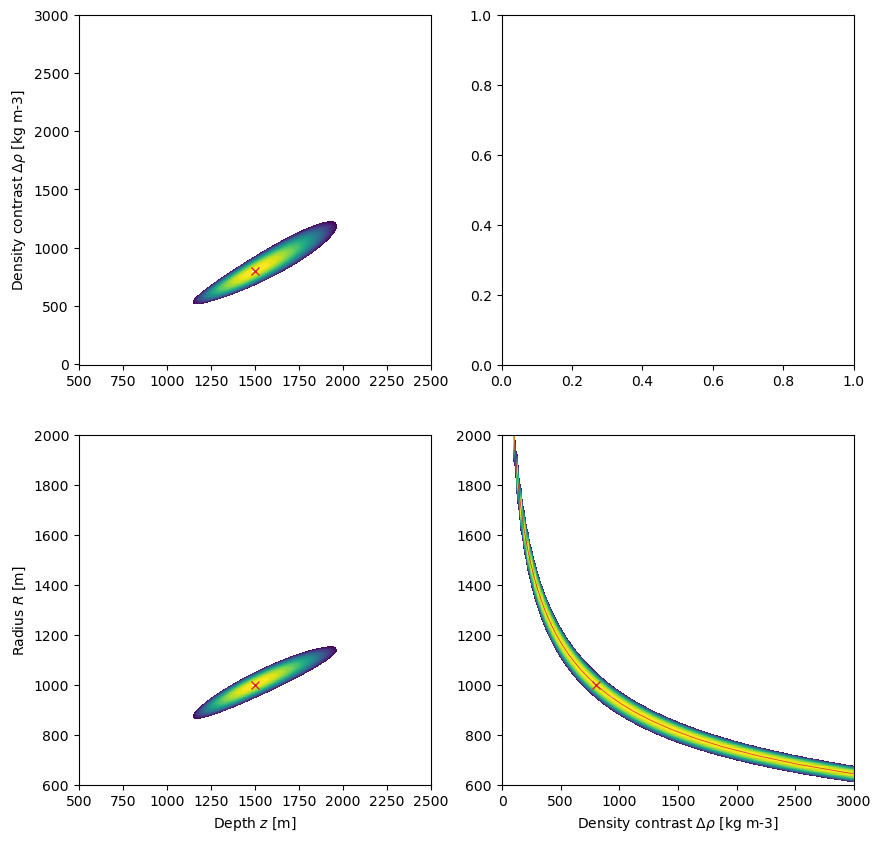

In [8]:

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
cmap = plt.get_cmap("tab10")

axs[0,0].contourf(zv_R, rhov_R, post_logpdf_zrho.reshape(100,100),
            levels = np.linspace(0, 1200, 100, endpoint = True),
            cmap = "viridis")
axs[0,0].plot(z_true, rho_true, 'x', color = cmap(3), label = 'Truth')
#axs[0,0].legend()
#cbar = plt.colorbar(ax = axs[0,0])
#axs[0,0].xlim([-5,3000])
axs[0,0].set_ylim([-5,3000])

axs[1,0].contourf(zv_rho, Rv_rho, post_logpdf_zR.reshape(100,100),
            levels = np.linspace(0, 1200, 100, endpoint = True),
            cmap = "viridis")
axs[1,0].plot(z_true, R_true, 'x', color = cmap(3), label = 'Truth')
#axs[1,0].legend()
#cbar = plt.colorbar(ax = axs[1,0])
#axs[1,0].xlim([-5,3000])
axs[1,0].set_ylim([600,2000])

axs[1,1].contourf(rhov_z, Rv_z, post_logpdf_rhoR.reshape(100,100),
            levels = np.linspace(0, 1200, 100, endpoint = True),
            cmap = "viridis")
#cbar = plt.colorbar(ax = axs[1,1])
R_tmp = np.linspace(300, 2000, 50)
axs[1,1].plot(rho_true*R_true**3/R_tmp**3, R_tmp, color = cmap(3), linewidth = 0.5, label = 'Analytical true \nsolution space')
axs[1,1].plot(rho_true, R_true, 'x', color = cmap(3), label = 'Truth')
#axs[1,1].legend()
axs[1,1].set_xlim([-5,3000])
axs[1,1].set_ylim([600,2000])

axs[0,0].set_ylabel(r"Density contrast $\Delta\rho$ [kg m-3]")
axs[1,1].set_xlabel(r"Density contrast $\Delta\rho$ [kg m-3]")
axs[1,0].set_ylabel(r"Radius $R$ [m]")
axs[1,0].set_xlabel(r"Depth $z$ [m]")
#cbar.set_label(r"Log-posterior contours")

In [9]:
grid_size = 50
zv, rhov, Rv = np.meshgrid(np.linspace(500,2500,grid_size), 
                            np.linspace(10,3000,grid_size), 
                            np.linspace(600,2000,grid_size))
zv_f = zv.flatten()
rhov_f = rhov.flatten()
Rv_f = Rv.flatten()

post_logpdf = np.zeros(grid_size**3)
for i in range(grid_size**3):
    post_logpdf[i] = posterior.logpdf(np.array([zv_f[i], rhov_f[i], Rv_f[i]]))

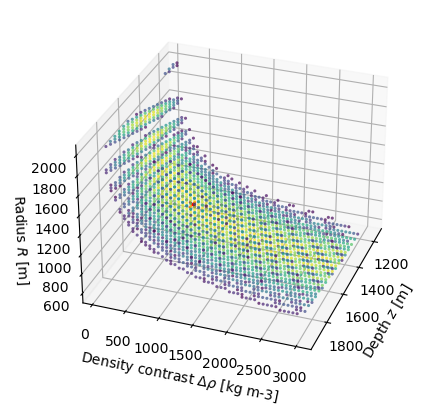

In [10]:
# Creating figure
fig = plt.figure()
ax = plt.axes(projection="3d")
# Creating plot
post_logpdf_3D = post_logpdf.reshape((grid_size, grid_size, grid_size))
post_logpdf_3D[post_logpdf_3D<0] = np.nan
mask = np.isfinite(post_logpdf_3D)
ax.scatter3D(zv[mask], rhov[mask], Rv[mask], c=post_logpdf_3D[mask], alpha=0.7, marker='.', edgecolors = "none", plotnonfinite = False)
ax.scatter3D(z_true, rho_true, R_true, color = "r", marker = 'x')
ax.set_xlabel(r"Depth $z$ [m]")
ax.set_ylabel(r"Density contrast $\Delta\rho$ [kg m-3]")
ax.set_zlabel(r"Radius $R$ [m]")
ax.view_init(30, 20)

#### Posterior sampling with Metropolis-Hastings

To solve the inverse problem we sample the posterior distribution. First we use the Metropolis-Hastings sampler and plot the 1D and 2D marginals of the posterior distribution.  

In [11]:
# Try the Metropolis Hasting sampler
x0 = np.array([1000,2000,1000])
MHsampler = cuqi.sampler.MetropolisHastings(posterior, x0 = x0, scale = 1)
samplesMH = MHsampler.sample_adapt(66000, 33000)

Sample 99000 / 99000

Average acceptance rate: 0.6253181818181818 MCMC scale: 1 



/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/samples/_samples.py:576: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if tight_layout: plt.tight_layout()


Depth effective sample size: 89.88481396638964
Density contrast effective sample size: 1.4543590206708021
Radius effective sample size: 1.6125063907928787


<Figure size 640x480 with 0 Axes>

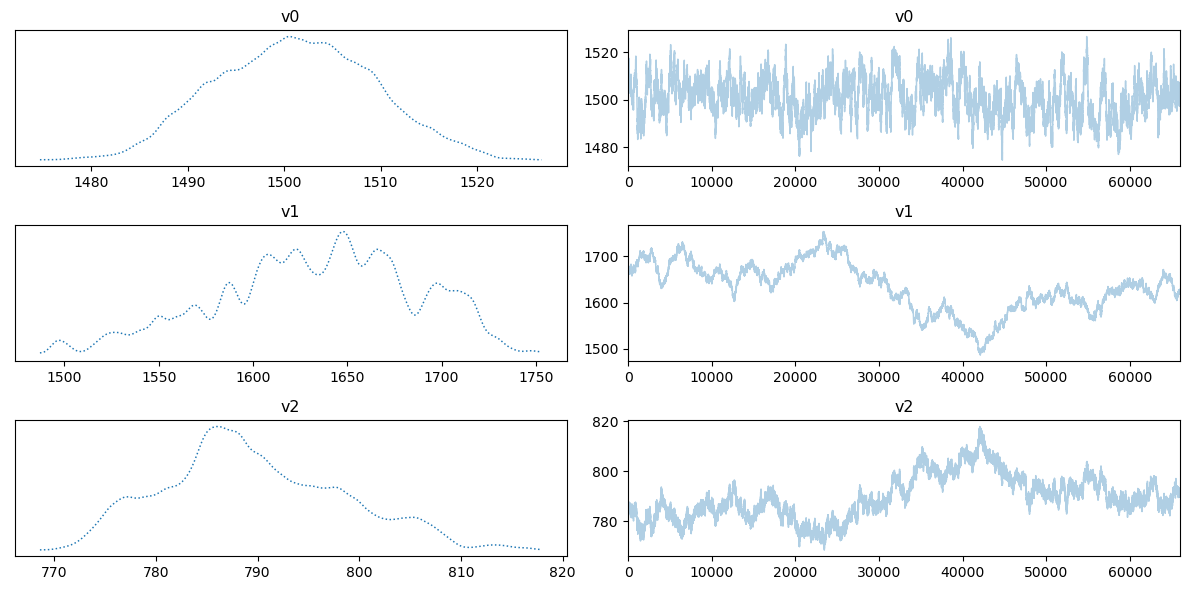

<Figure size 640x480 with 0 Axes>

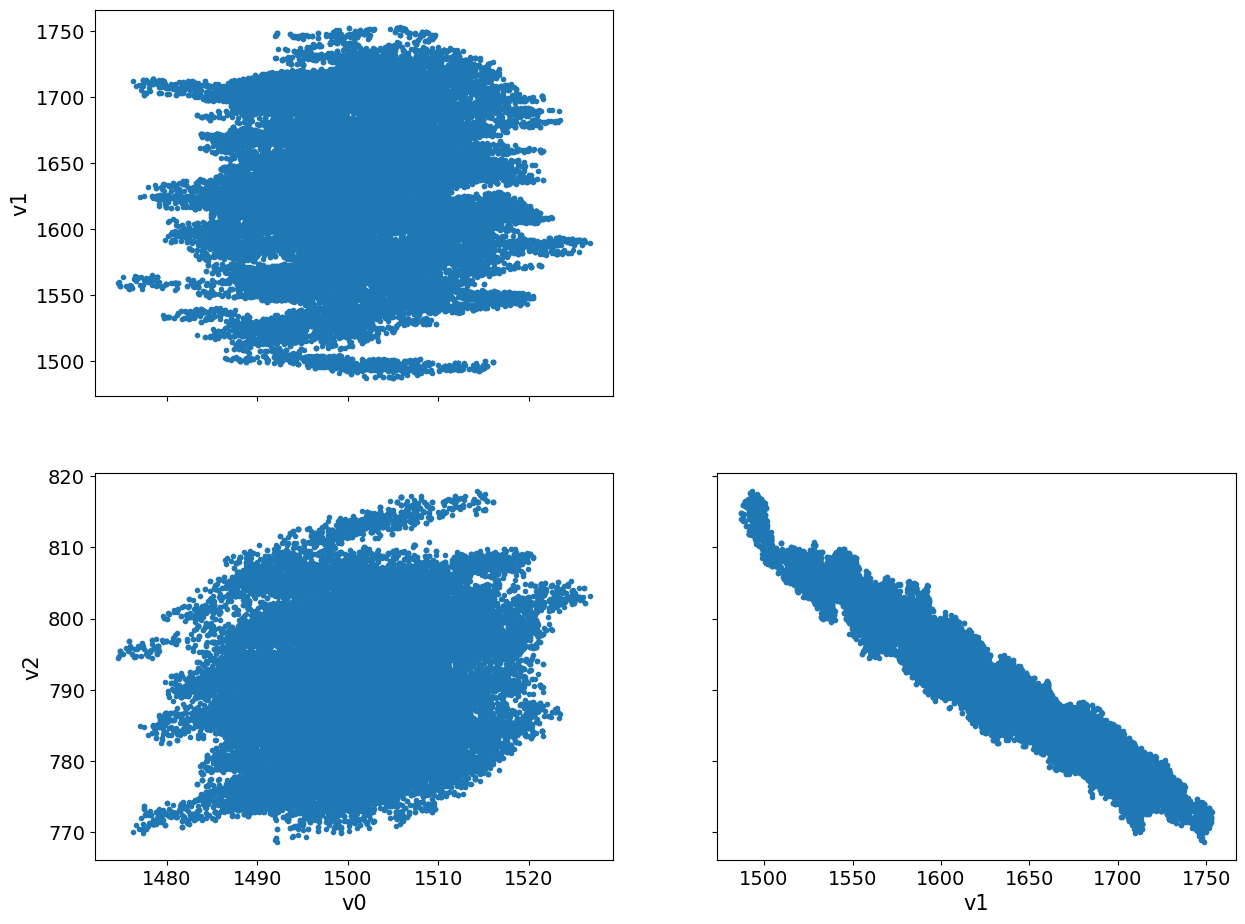

In [12]:
plt.figure()
samplesMH.plot_trace()

plt.figure()
samplesMH.plot_pair()

# Effective sample size
ess = samplesMH.compute_ess()
print("Depth effective sample size: {}".format(ess[0]))
print("Density contrast effective sample size: {}".format(ess[1]))
print("Radius effective sample size: {}".format(ess[2]))

In the 1D marginals we see that the posterior samples of the depth parameter constract near the true value. The chains and 1D marginals for the other two parameters look poor and as if they have not converged. Looking at the 2D marginals we see that the density contrast and radius of the body is in fact strongly correlated, which was expected according to the model. From the model we can derive that the relationship between them is given $\Delta\rho = (\Delta\rho_{true} R_{true}^3)/R^3$. If we plot this curve along the 2D marginal of the samples, we see that they coincide. This means the sampler actually samples from the true solution space even though the chains look poor. However, the sampler moves slowly in the solution space and does not cover much of it. Eventually the samples would represent the entire posterior, but it will take a while. This is expected behaviour since Metropolis-Hastings is not a suitable sampler for highy correlated parameters.

1227.8901971720181


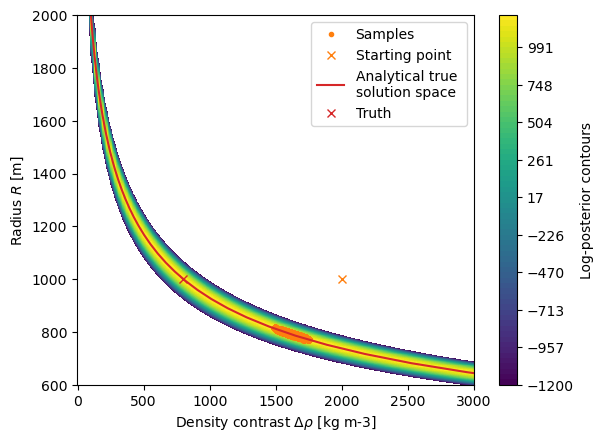

In [13]:
plt.figure()
print(max(post_logpdf_rhoR))
plt.contourf(rhov_z, Rv_z, post_logpdf_rhoR.reshape(100,100), 
            levels = np.linspace(-1200, 1200, 70, endpoint = True),
            cmap = "viridis")
plt.plot(samplesMH.samples[1,:], samplesMH.samples[2,:], '.', color = cmap(1), label = "Samples")
plt.plot(x0[1], x0[2], 'x', color = cmap(1), label = 'Starting point')
plt.plot(rho_true*R_true**3/R_tmp**3, R_tmp, color = cmap(3), label = 'Analytical true \nsolution space')
plt.plot(rho_true, R_true, 'x', color = cmap(3), label = 'Truth')
plt.legend()
plt.xlim([-5,3000])
plt.ylim([600,2000])
cbar = plt.colorbar(extend='both')
plt.xlabel(r"Density contrast $\Delta\rho$ [kg m-3]")
plt.ylabel(r"Radius $R$ [m]")
cbar.set_label(r"Log-posterior contours")


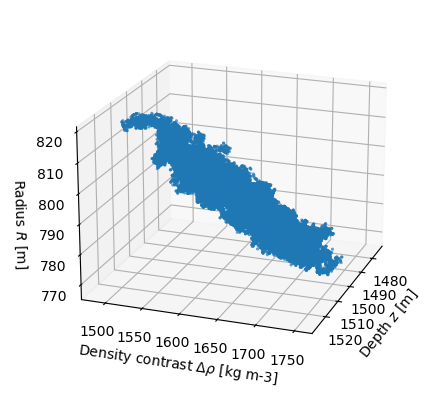

In [14]:
# Creating figure
fig = plt.figure()
ax = plt.axes(projection="3d")
# Creating plot
ax.scatter3D(samplesMH.samples[0,:], samplesMH.samples[1,:], samplesMH.samples[2,:], alpha=0.7, marker='.', edgecolor = "none")
ax.set_xlabel(r"Depth $z$ [m]")
ax.set_ylabel(r"Density contrast $\Delta\rho$ [kg m-3]")
ax.set_zlabel(r"Radius $R$ [m]")
ax.view_init(20, 20)

#### Posterior sampling with NUTS

When the parameters are correlated, gradient based samplers are often more efficient for sampling the entire posterior. The gradient information helps the sampler .... Below we use the NUTS sampler to sample and plot the posterior:

In [15]:
# Try the NUTS sampler
NUTSsampler = cuqi.sampler.NUTS(posterior, x0 = x0)
samplesNUTS = NUTSsampler.sample_adapt(1000, 100)

/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/sampler/_hmc.py:222: RuntimeWarning: overflow encountered in exp
  alpha_prime = min(1, np.exp(diff_Ham))     # logalpha_p = min(0, H_p - H)


Sample 1100 / 1100


Depth effective sample size: 561.4256720821996
Density contrast effective sample size: 28.294641546190817
Radius effective sample size: 27.940754232995705


/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/samples/_samples.py:576: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if tight_layout: plt.tight_layout()


<Figure size 640x480 with 0 Axes>

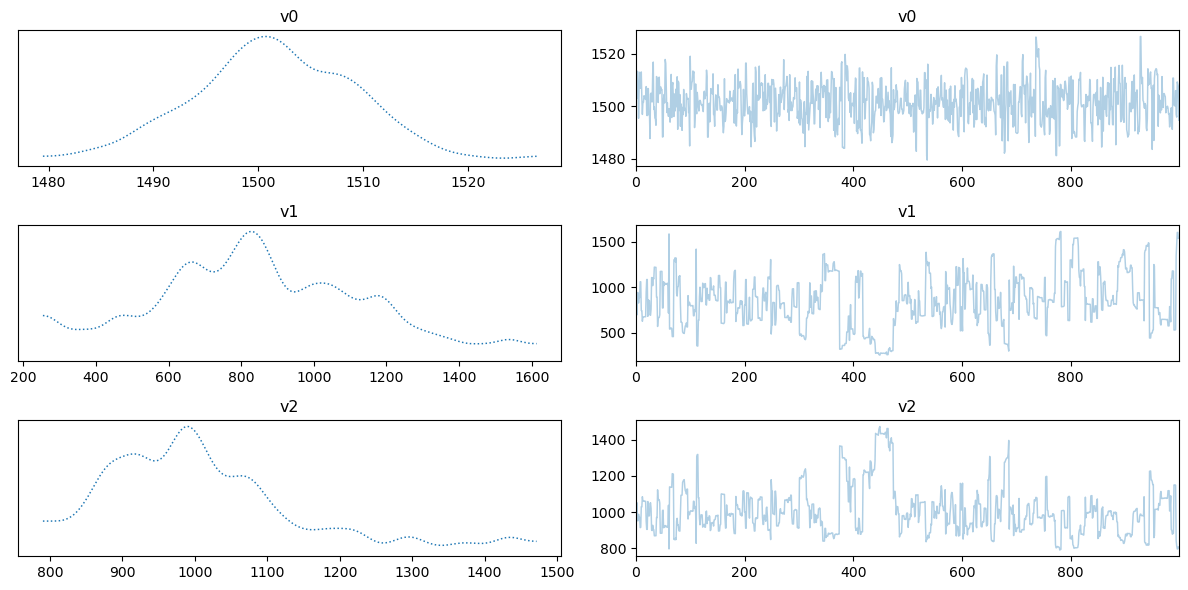

<Figure size 640x480 with 0 Axes>

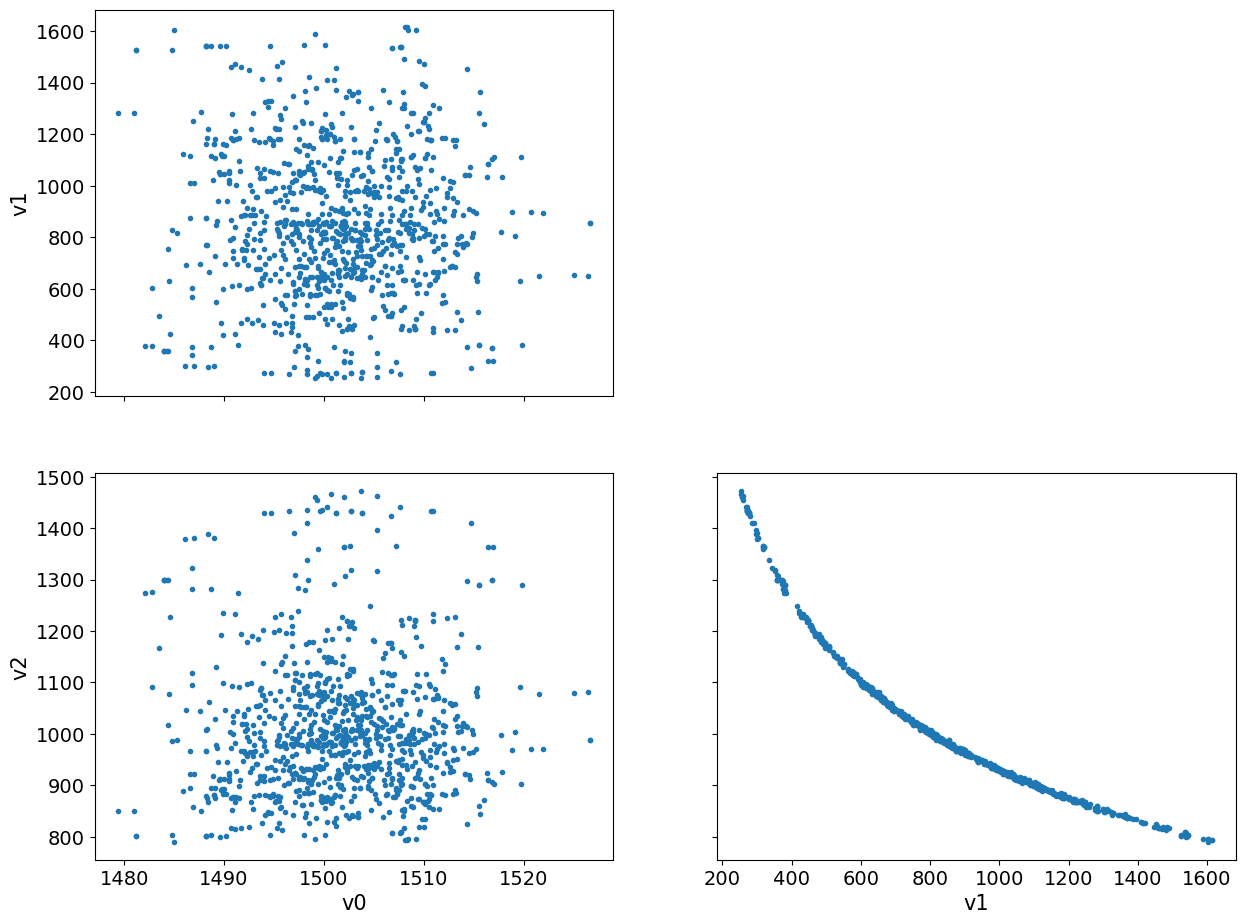

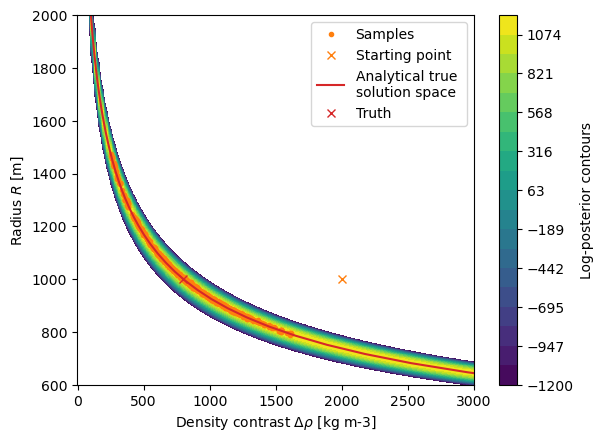

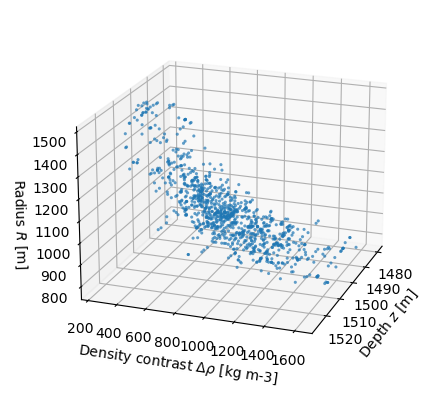

In [16]:
plt.figure()
samplesNUTS.plot_trace()

plt.figure()
samplesNUTS.plot_pair()

# Effective sample size
ess = samplesNUTS.compute_ess()
print("Depth effective sample size: {}".format(ess[0]))
print("Density contrast effective sample size: {}".format(ess[1]))
print("Radius effective sample size: {}".format(ess[2]))

plt.figure()
plt.contourf(rhov_z, Rv_z, post_logpdf_rhoR.reshape(100,100), 
            levels = np.linspace(-1200, 1200, 20, endpoint = True),
            cmap = "viridis")
plt.plot(samplesNUTS.samples[1,:], samplesNUTS.samples[2,:], '.', color = cmap(1), label = "Samples")
plt.plot(x0[1], x0[2], 'x', color = cmap(1), label = 'Starting point')
plt.plot(rho_true*R_true**3/R_tmp**3, R_tmp, color = cmap(3), label = 'Analytical true \nsolution space')
plt.plot(rho_true, R_true, 'x', color = cmap(3), label = 'Truth')
plt.legend()
plt.xlim([-5,3000])
plt.ylim([600,2000])
cbar = plt.colorbar()
cbar.set_label(r"Log-posterior contours")
plt.xlabel(r"Density contrast $\Delta\rho$ [kg m-3]")
plt.ylabel(r"Radius $R$ [m]")

# Creating figure
fig = plt.figure()
ax = plt.axes(projection="3d")
# Creating plot
ax.scatter3D(samplesNUTS.samples[0,:], samplesNUTS.samples[1,:], samplesNUTS.samples[2,:], alpha=0.7, marker='.', edgecolor = "none")
ax.set_xlabel(r"Depth $z$ [m]")
ax.set_ylabel(r"Density contrast $\Delta\rho$ [kg m-3]")
ax.set_zlabel(r"Radius $R$ [m]")
ax.view_init(20, 20)


The 1D marginals show us that the NUTS sampler has much better chains than the Metropolis-Hastings sampler. Furthermore, NUTS also infers the depth parameter well, but the other two parameters have very wide spreads. The 2D marginals show us the correlation between the density contrast and radius again. However, when plotting the samples along with the analytical solution curve we see that much more of the space is covered in very few samples. The downside of NUTS is that it runs much slower than Metropolis-Hastings. In this case we see that 99000 samples with Metropolis-Hastings takes about the same time as 1000 samples with NUTS. However, the effective sample sizes are comparable if not better with NUTS.

#### More informative prior

We saw that the density contrast and radius can not be determined uniquely from the data. Our only hope to improve the solution is with a good prior. We formulate a Gaussian prior to imitate the situation where we are quite sure about the density contrast, but not the radius or depth. This might happen if we know we are looking for iron ore in sedimentary rock, but not how much or how deep down.

/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/sampler/_hmc.py:222: RuntimeWarning: overflow encountered in exp
  alpha_prime = min(1, np.exp(diff_Ham))     # logalpha_p = min(0, H_p - H)


Sample 1100 / 1100


/zhome/d2/8/97872/anaconda3/envs/cuqi/lib/python3.10/site-packages/cuqi/samples/_samples.py:576: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if tight_layout: plt.tight_layout()


array([[<AxesSubplot:ylabel='v1'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='v0', ylabel='v2'>,
        <AxesSubplot:xlabel='v1'>]], dtype=object)

<Figure size 640x480 with 0 Axes>

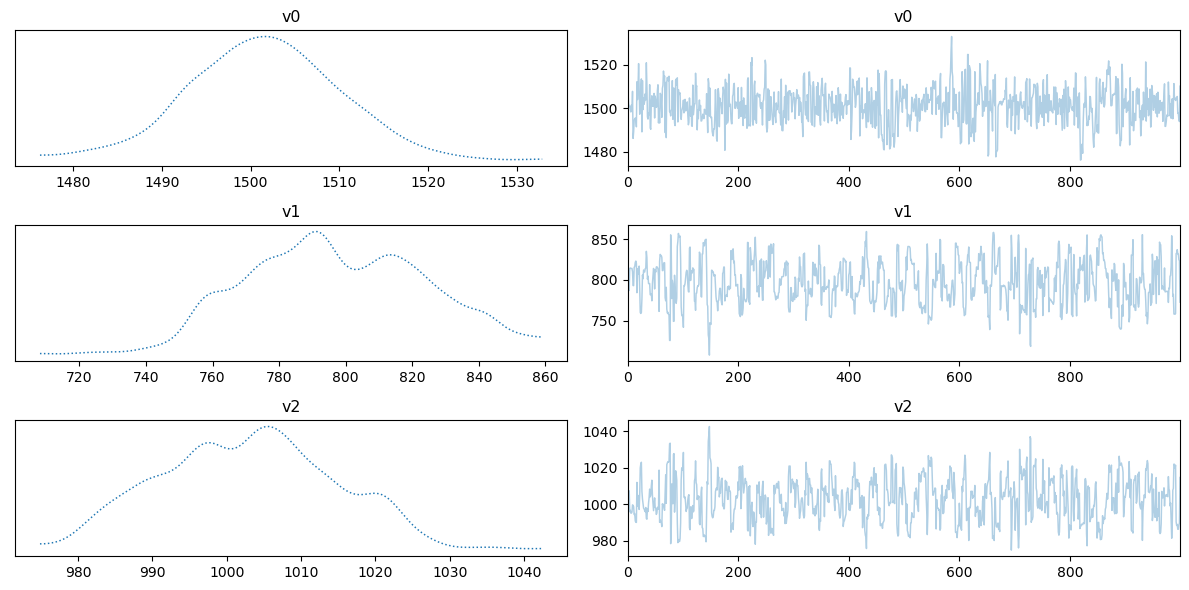

<Figure size 640x480 with 0 Axes>

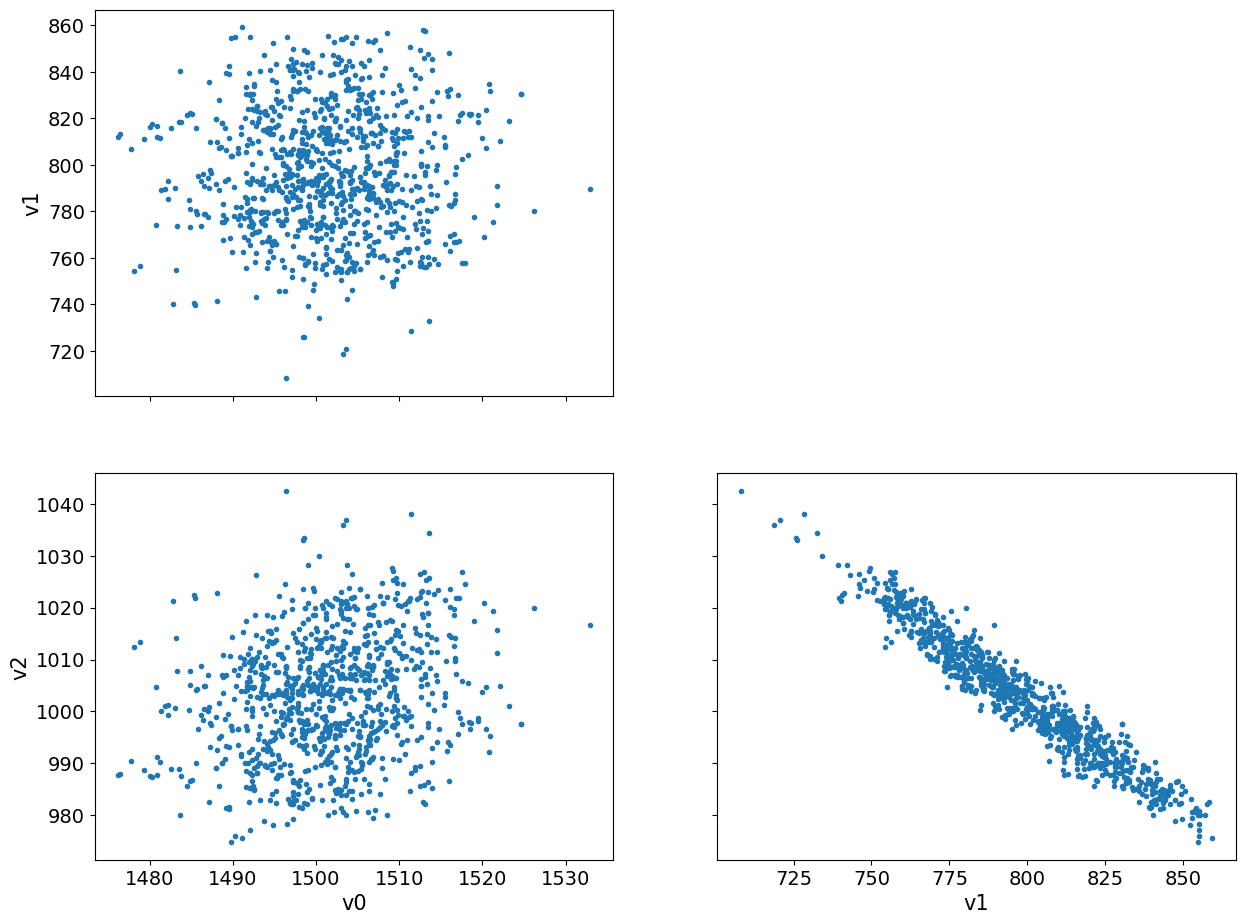

In [22]:
# Prior
x = cuqi.distribution.GaussianCov(np.array([1550, 800, 950]), np.array([500, 30, 300])**2)

# Posterior
joint = cuqi.distribution.JointDistribution(y, x)
posterior = joint(y=gz_noisy)

# Try the metropolis Hasting sampler
NUTSsampler2 = cuqi.sampler.NUTS(posterior, x0 = x0)
samplesNUTS2 = NUTSsampler2.sample_adapt(1000, 100)

plt.figure()
samplesNUTS2.plot_trace()

plt.figure()
samplesNUTS2.plot_pair()


Depth effective sample size: 520.0922629895723
Density contrast effective sample size: 243.92729634760408
Radius effective sample size: 241.72399601151358


Text(0, 0.5, 'Radius $R$ [m]')

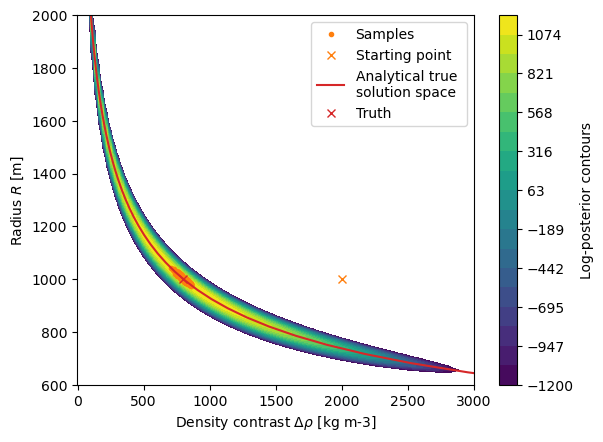

In [23]:
# Effective sample size
ess = samplesNUTS2.compute_ess()
print("Depth effective sample size: {}".format(ess[0]))
print("Density contrast effective sample size: {}".format(ess[1]))
print("Radius effective sample size: {}".format(ess[2]))

post_logpdf2 = np.zeros(len(rhov_z_f))
for i in range(len(rhov_z_f)):
    post_logpdf2[i] = posterior.logpdf(np.array([z_true, rhov_z_f[i], Rv_z_f[i]]))

plt.figure()
plt.contourf(rhov_z, Rv_z, post_logpdf2.reshape(100,100), 
            levels = np.linspace(-1200, 1200, 20, endpoint = True),
            cmap = "viridis")
plt.plot(samplesNUTS2.samples[1,:], samplesNUTS2.samples[2,:], '.', color = cmap(1), label = "Samples")
plt.plot(x0[1], x0[2], 'x', color = cmap(1), label = 'Starting point')
plt.plot(rho_true*R_true**3/R_tmp**3, R_tmp, color = cmap(3), label = 'Analytical true \nsolution space')
plt.plot(rho_true, R_true, 'x', color = cmap(3), label = 'Truth')
plt.legend()
plt.xlim([-5,3000])
plt.ylim([600,2000])
cbar = plt.colorbar()
cbar.set_label(r"Log-posterior contours")
plt.xlabel(r"Density contrast $\Delta\rho$ [kg m-3]")
plt.ylabel(r"Radius $R$ [m]")

First of all we see that the NUTS sampler runs much faster because the solution space is ... We also see the smaller solution space in the 2D marginals. In the 1D marginals we see that the good prior on the density contrast leads to much better inference for the radius. 